In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii

BANDS = ['g', 'r', 'i']
UPPER_LIMIT_MAGS = {
    'pstarr' : {'g': 23.3, 'r': 23.2, 'i': 23.1},
    'ztf': {'g': 23.3, 'r': 23.2, 'i': 23.1}
}

In [2]:
from typing import Optional

def img_ab_mag_to_flux(mag: np.ndarray, zero_point: np.ndarray, magerr: Optional[np.ndarray] = None) -> np.ndarray:
    """Inverse of img_flux_to_ab_mag."""
    flux = 10 ** ((mag - zero_point) / -2.5)
    if magerr is not None:
        fluxerr = (magerr * (np.log(10) * flux)) / 2.5
        return flux, fluxerr
    return flux

def get_snr_from_mag(mag, magerr, zp):
        flux, fluxerr = img_ab_mag_to_flux(mag, zero_point=zp, magerr=magerr)
        return flux / fluxerr

In [ ]:
from Extracting.Catalogs import PSTARR_Catalog
test = PSTARR_Catalog((0,0.25), (30, 30.25))
tab = test.get_data()

1070


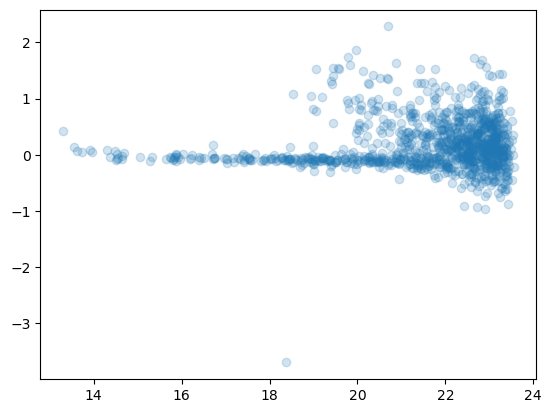

In [ ]:
mask = (tab['gPSFMag'] > 0) & (tab['gKronMag'] > 0)
print(len(tab[mask]))
plt.scatter(tab['gPSFMag'][mask], tab['gPSFMag'][mask] - tab['gKronMag'][mask], alpha=0.2)

# Look at one field (000513)

In [3]:
g_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000512_g.ecsv')
r_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000512_r.ecsv')
i_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000512_i.ecsv')
tables = {'g': g_tab, 'r': r_tab, 'i': i_tab}
print(len(g_tab), len(r_tab), len(i_tab))
g_tab

84263 85055 85879


ra,dec,ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_sepExtractionFlag,ZTF_gKronMag,ZTF_gKronMagErr,ZTF_gKronCircleFlag,ZTF_gPSFMag,ZTF_gPSFMagErr,ZTF_gPSFFlags,ZTF_g_zero_pt_mag,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_rKronMag,PSTARR_iKronMag,PSTARR_gKronMagErr,PSTARR_rKronMagErr,PSTARR_iKronMagErr,PSTARR_gApMag,PSTARR_rApMag,PSTARR_iApMag,PSTARR_gApMagErr,PSTARR_rApMagErr,PSTARR_iApMagErr,PSTARR_gPSFMag,PSTARR_rPSFMag,PSTARR_iPSFMag,PSTARR_gPSFMagErr,PSTARR_rPSFMagErr,PSTARR_iPSFMagErr,PSTARR_primaryDetection,PSTARR_ra,PSTARR_dec,association_separation_arcsec,Catalog
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
89.8252803926708,13.546868492476941,1.0070536136627197,8.0,4.0,369.0,371.0,89.0,91.0,369.9341484217535,89.75706598335314,0.54262990854324,0.4818265065110021,-0.1137592800655276,0.01424625875196764,0.0144817864349402,-0.0034294202859503995,0.7937126755714417,0.6280737519264221,-0.6548266410827637,1.9388437271118164,2.1835134029388428,0.9155223369598389,18.715261459350586,22.748184204101562,3.8335094451904297,9.997421264648438,370.0,90.0,370.0,90.0,0.0,21.235798750197027,0.09018655326492117,0.0,21.90237440972002,0.08041246598960833,0.0,26.325,89.8252257489275,13.546915653562682,1.2425089825324669e+17,21.6811008453369,20.5632991790771,19.7035999298096,0.123291000723839,0.0405870005488396,0.0204130001366138,21.7112007141113,20.4496994018555,19.5937995910645,0.00807199999690056,0.00424400018528104,0.00285200006328523,22.1079006195068,20.6417007446289,19.6420001983643,0.0985080003738403,0.0287120006978512,0.012881999835372,1.0,89.8253350364141,13.5468213313912,0.5114672483606004,Both
90.02793164943512,13.549484701008765,1.0070536136627197,8.0,3.0,1078.0,1081.0,89.0,92.0,1079.4877915592429,90.4851881844825,0.5514433053988839,0.5970820688813494,-0.2641810669736804,0.01414878172653268,0.014153892040927646,-0.007068632336084648,0.91620272397995,0.5559657216072083,-0.8284801244735718,2.3012022972106934,2.1253068447113037,2.0363500118255615,20.773773193359375,26.819244384765625,4.00869083404541,13.283981323242188,1079.0,91.0,1079.0,91.0,0.0,21.01567263365471,0.07365524048764274,1.0,21.25906763131438,0.048607373093253727,0.0,26.325,90.02793852889572,13.54953543635273,1.2425090028108962e+17,-999.0,20.7082996368408,-999.0,-999.0,0.0693090036511421,-999.0,22.3269004821777,20.5058002471924,27.0774002075195,0.0121330004185438,0.00500300014391541,0.0848129987716675,22.2644004821777,20.6229000091553,-999.0,0.216766998171806,0.0441810004413128,4.53609991073608,1.0,90.0279247699745,13.5494339656648,0.3684546343497543,Both
90.19942741591709,13.551860385082584,1.0070536136627197,10.0,3.0,1679.0,1681.0,89.0,92.0,1680.0454112683608,90.21684574474284,0.5056648369186825,0.6547290525035314,0.02044820161233507,0.010167443663200928,0.01620631980798264,1.4309891037678802e-05,0.8108533620834351,0.7091619968414307,1.4369134902954102,1.9800952672958374,1.5292807817459106,-0.12368287891149521,24.548625946044922,27.456680297851562,5.109663009643555,19.27203369140625,1680.0,90.0,1680.0,90.0,0.0,18.873843991317656,0.014477048334908484,0.0,20.63866959574754,0.03545550281981554,0.0,26.325,90.19951517641547,13.551870873825868,1.2426090199340267e+17,-999.0,20.3985004425049,19.8087997436523,-999.0,0.0271690003573895,0.0371589995920658,23.4655990600586,20.3286991119385,19.7

In [4]:
for k in g_tab.colnames:
    if 'flag' in k.lower():
        print(k)

ZTF_sepExtractionFlag
ZTF_gKronCircleFlag
ZTF_gPSFFlags


In [5]:
# Set values <=0 to the upper limit for ZTF
for band in BANDS:
    tab = tables[band]
    upper_lim_mask = tab[f'ZTF_{band}PSFFlags'] == 4
    tab[f'ZTF_{band}PSFMag'][upper_lim_mask] = UPPER_LIMIT_MAGS['ztf'][band]   # 4 means flux was negative
    tab[f'ZTF_{band}_upper_lim'] = False
    tab[f'ZTF_{band}_upper_lim'][upper_lim_mask] = True
    tables[band] = tab

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


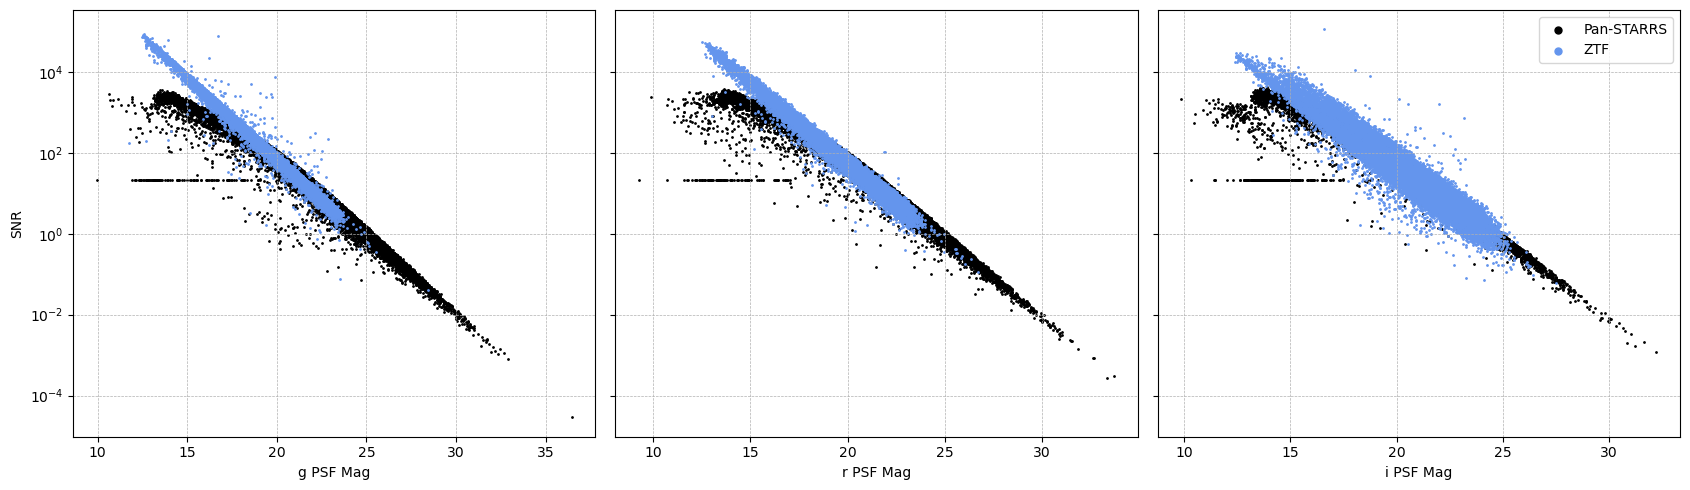

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    # Plot
    ax.scatter(tab[f'PSTARR_{band}PSFMag'], pstarr_snr, color='k', label='Pan-STARRS', s=1)
    ax.scatter(tab[f'ZTF_{band}PSFMag'], ztf_snr, color='cornflowerblue', label='ZTF', s=1)

    # Formatting
    ax.set_yscale('log')
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')

axes[0].set_ylabel(f'SNR')
axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


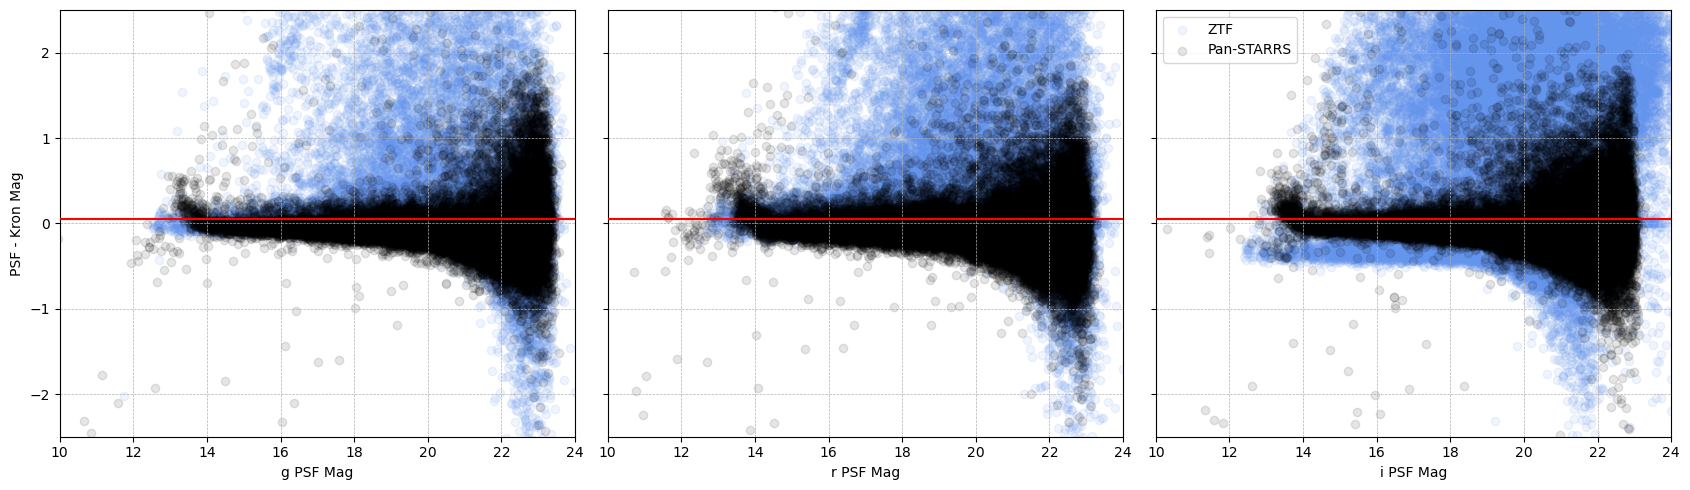

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    pstarr_mask = pstarr_snr > 2
    ztf_mask = ztf_snr > 2

    # Plot
    # Without upper lims
    ax.scatter(
        tab[ztf_mask][f'ZTF_{band}PSFMag'],
        tab[ztf_mask][f'ZTF_{band}PSFMag'] - tab[ztf_mask][f'ZTF_{band}KronMag'],
        color='cornflowerblue',
        label='ZTF',
        alpha=0.1
    )
    ax.scatter(
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'],
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'] - tab[pstarr_mask][f'PSTARR_{band}KronMag'],
        color='k',
        label='Pan-STARRS',
        alpha=0.1
    )

    # Formatting
    ax.axhline(0.05, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')
    ax.set_ylim((-2.5, 2.5))
    ax.set_xlim((10, 24))

axes[0].set_ylabel(f'PSF - Kron Mag')
axes[-1].legend(markerscale=1)
plt.tight_layout()
plt.show()

Table size: 84263


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Table size: 85055
Table size: 85879


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/4012408540.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(markerscale=5)


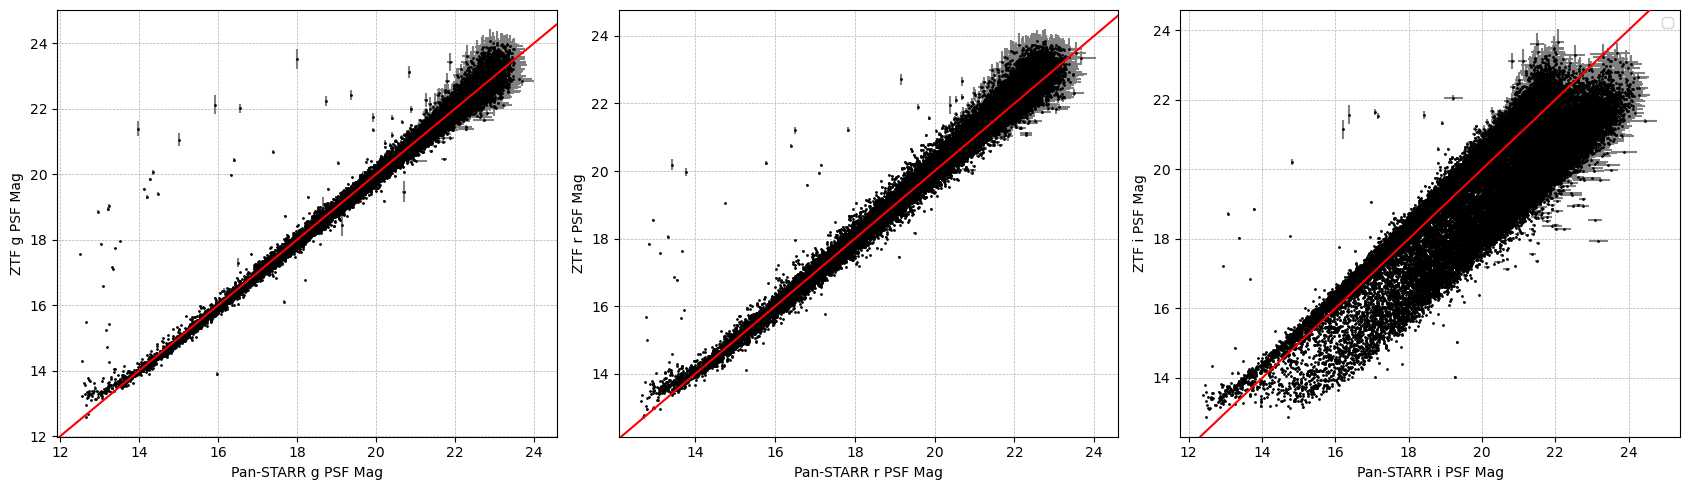

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]
    print(f'Table size: {len(tab)}')

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)
    ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

    # Plot
    # Without upper lims
    mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        color='k',
        linestyle="None",
        fmt="o",
        markersize=1,
        ecolor='gray',
    )
    # # Just upper lims
    # mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
    # print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(np.sum(mask))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='k',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    #     ecolor='gray',
    # )

    # ##### Only in PSTARR #####
    # # Mask
    # pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
    # mask = pstarr_mask & (pstarr_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     upper_lims,
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(len(upper_lims))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='blue',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # ##### Only in ZTF #####
    # # Mask
    # ztf_mask = (tab['Catalog'] == 'ZTF')
    # mask = ztf_mask & (ztf_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     upper_lims,
    #     yerr=[0.25 for _ in range(len(upper_lims))],
    #     xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
    #     uplims=True,
    #     color='forestgreen',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


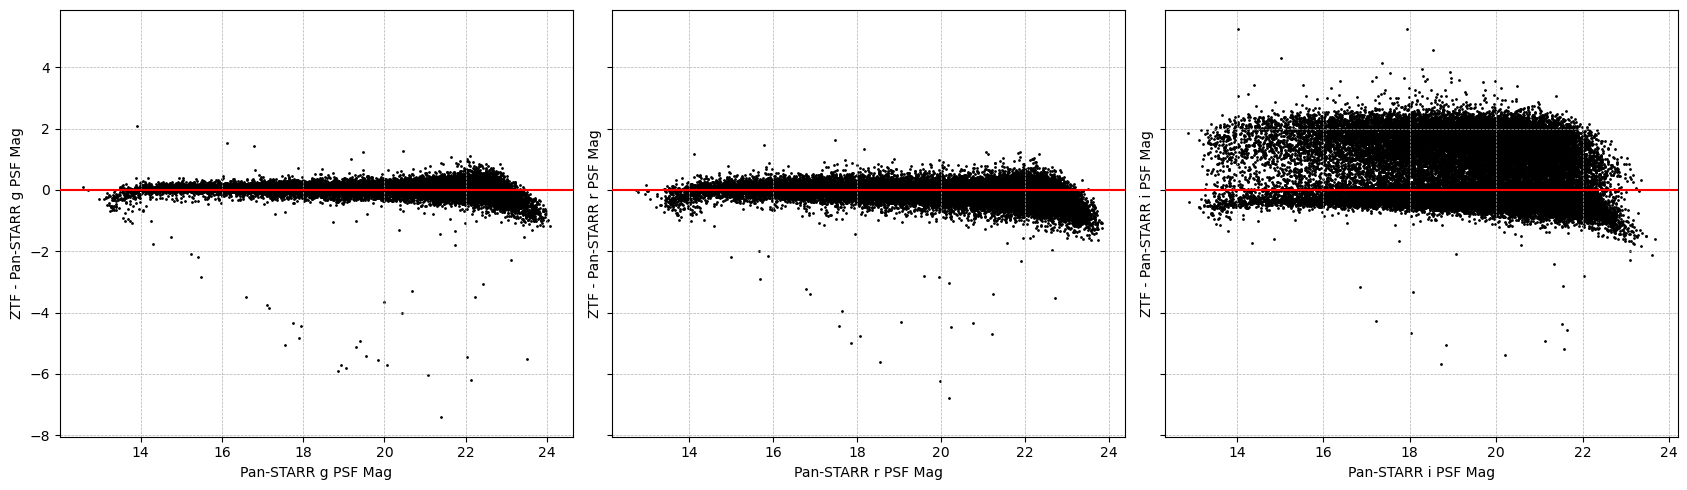

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)

    # Plot
    mask = both_mask & snr_mask
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_17819/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


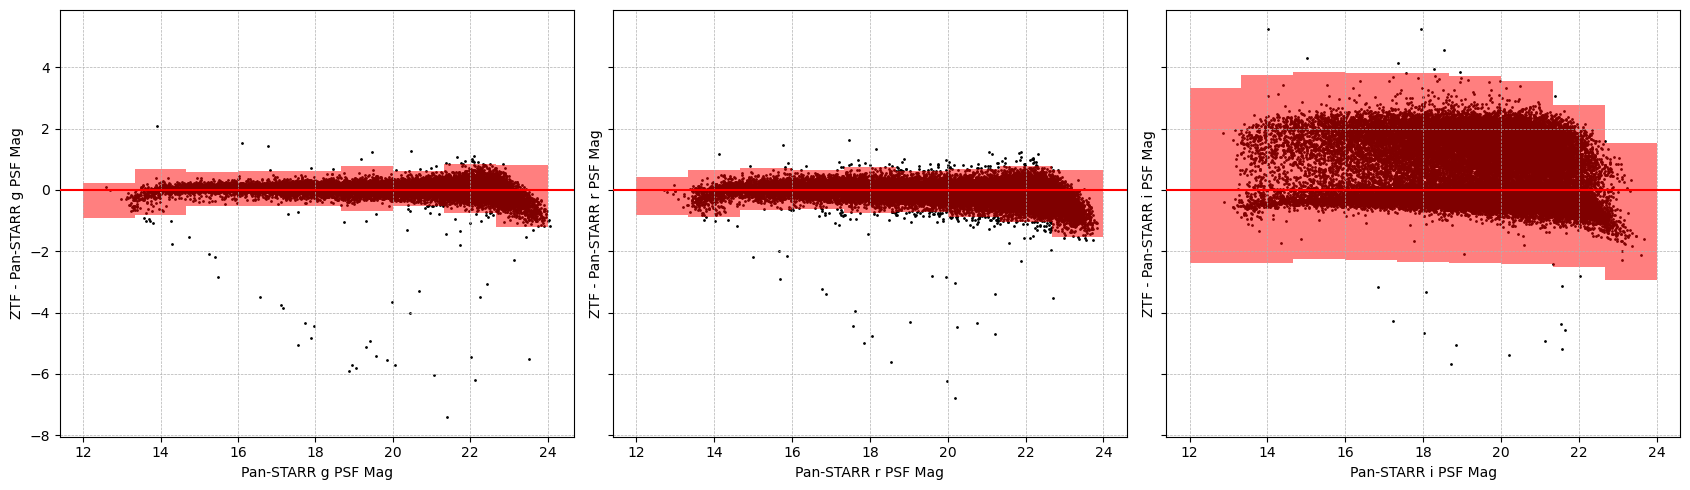

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)
    mask = both_mask & snr_mask

    # Get the 3-sigma boundaries on delta mag
    mag_bin_edges = np.linspace(12, 24, num=10)
    bin_means, bin_stds = [], []
    for i in range(len(mag_bin_edges) - 1):
        lower, upper = mag_bin_edges[i], mag_bin_edges[i+1]
        bin_mask = both_mask & snr_mask & (tab[f'PSTARR_{band}PSFMag'] > lower) & (tab[f'PSTARR_{band}PSFMag'] < upper)

        bin_means.append(np.mean(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))
        bin_stds.append(np.std(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))

    # Plot
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Plot the bin mean +- 3sigma with rectangles for each bin
    for lower, upper, mean, std in zip(mag_bin_edges[:-1], mag_bin_edges[1:], bin_means, bin_stds):
        rect = plt.Rectangle(
            (lower, mean - (3 * std)),
            upper - lower,
            6 * std,
            color='red',
            alpha=0.5,
            lw=0,
        )
        ax.add_patch(rect)

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()